 Mission de référence : analyse prédictive et segmentation des 
clients d’Olist 

Ce projet s’inscrit dans le secteur du e-commerce, caractérisé par des volumes de données transactionnelles importants, une forte concurrence et des enjeux majeurs de fidélisation client. Les données Olist sont relationnelles, temporelles et orientées comportement client.

Problématique :
Comment segmenter les clients de la plateforme Olist à partir de leurs comportements d’achat et prédire l’évolution du chiffre d’affaires et de la demande par segment afin d’optimiser les décisions marketing et commerciales ?



Structuration et exploration des données

In [6]:
#chargement des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import silhouette_score, mean_squared_error, r2_score, classification_report
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC

In [9]:
#chargement des données
customers = pd.read_csv("olist_customers_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv", parse_dates=["order_purchase_timestamp"])
order_items = pd.read_csv("olist_order_items_dataset.csv")
payments = pd.read_csv("olist_order_payments_dataset.csv")
reviews = pd.read_csv("olist_order_reviews_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")


In [10]:
#structuration et nettoyage des données
# Jointures principales
df = orders.merge(customers, on="customer_id")
df = df.merge(order_items, on="order_id")
df = df.merge(payments, on="order_id", how="left")
df = df.merge(reviews, on="order_id", how="left")

# Nettoyage
df = df[df["order_status"] == "delivered"]
df = df.dropna(subset=["order_purchase_timestamp"])


In [11]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,1.0,credit_card,1.0,18.12,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,3.0,voucher,1.0,2.00,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,2.0,voucher,1.0,18.59,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,...,1.0,boleto,1.0,141.46,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,1.0,credit_card,3.0,179.12,e73b67b67587f7644d5bd1a52deb1b01,5.0,NaN,NaN,2018-08-18 00:00:00,2018-08-22 19:07:58


In [12]:
df.describe()

,order_purchase_timestamp,customer_zip_code_prefix,order_item_id,price,freight_value,payment_sequential,payment_installments,payment_value,review_score
count,115723,115723.000000,115723.000000,115723.000000,115723.00000,115720.000000,115720.000000,115720.000000,114862.000000
mean,2017-12-31 09:55:44.254227712,35079.679519,1.197048,119.911096,19.98140,1.091272,2.940572,171.810794,4.080488
min,2016-09-15 12:16:38,1003.000000,1.000000,0.850000,0.00000,1.000000,0.000000,0.000000,1.000000
25%,2017-09-12 18:16:08,11310.000000,1.000000,39.900000,13.08000,1.000000,1.000000,60.850000,4.000000
50%,2018-01-18 21:40:03,24320.000000,1.000000,74.900000,16.28000,1.000000,2.000000,108.110000,5.000000
75%,2018-05-04 10:29:14,58805.500000,1.000000,132.900000,21.16000,1.000000,4.000000,188.940000,5.000000
max,2018-08-29 15:00:37,99980.000000,21.000000,6735.000000,409.68000,26.000000,24.000000,13664.080000,5.000000
std,NaN,29855.201461,0.701221,182.670252,15.71829,0.686737,2.776111,265.642619,1.347659


In [13]:
df.isna().sum()

order_id                              0
customer_id                           0
order_status                          0
order_purchase_timestamp              0
order_approved_at                    15
order_delivered_carrier_date          2
order_delivered_customer_date         8
order_estimated_delivery_date         0
customer_unique_id                    0
customer_zip_code_prefix              0
customer_city                         0
customer_state                        0
order_item_id                         0
product_id                            0
seller_id                             0
shipping_limit_date                   0
price                                 0
freight_value                         0
payment_sequential                    3
payment_type                          3
payment_installments                  3
payment_value                         3
review_id                           861
review_score                        861
review_comment_title             102139


In [14]:
snapshot_date = df["order_purchase_timestamp"].max()

client_features = (
    df.groupby("customer_unique_id")
    .agg(
        recency=("order_purchase_timestamp",
                 lambda x: (snapshot_date - x.max()).days),
        frequency=("order_id", "nunique"),
        monetary=("price", "sum"),
        avg_delivery_delay=("freight_value", "mean"),
        avg_review=("review_score", "mean")
    )
    .reset_index()
)


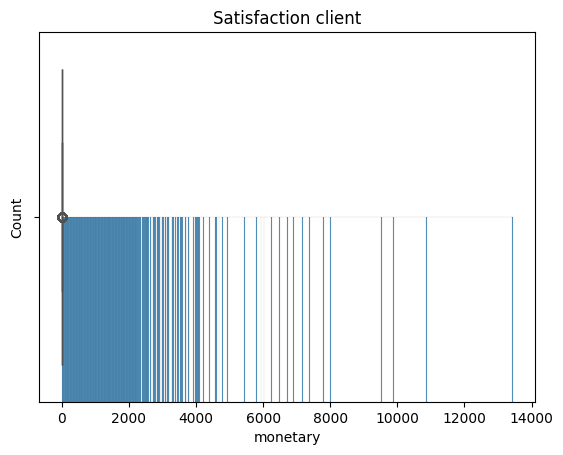

In [16]:
sns.histplot(client_features["monetary"])
plt.title("Distribution du montant total dépensé")

sns.boxplot(x=client_features["avg_review"])
plt.title("Satisfaction client")
plt.show()


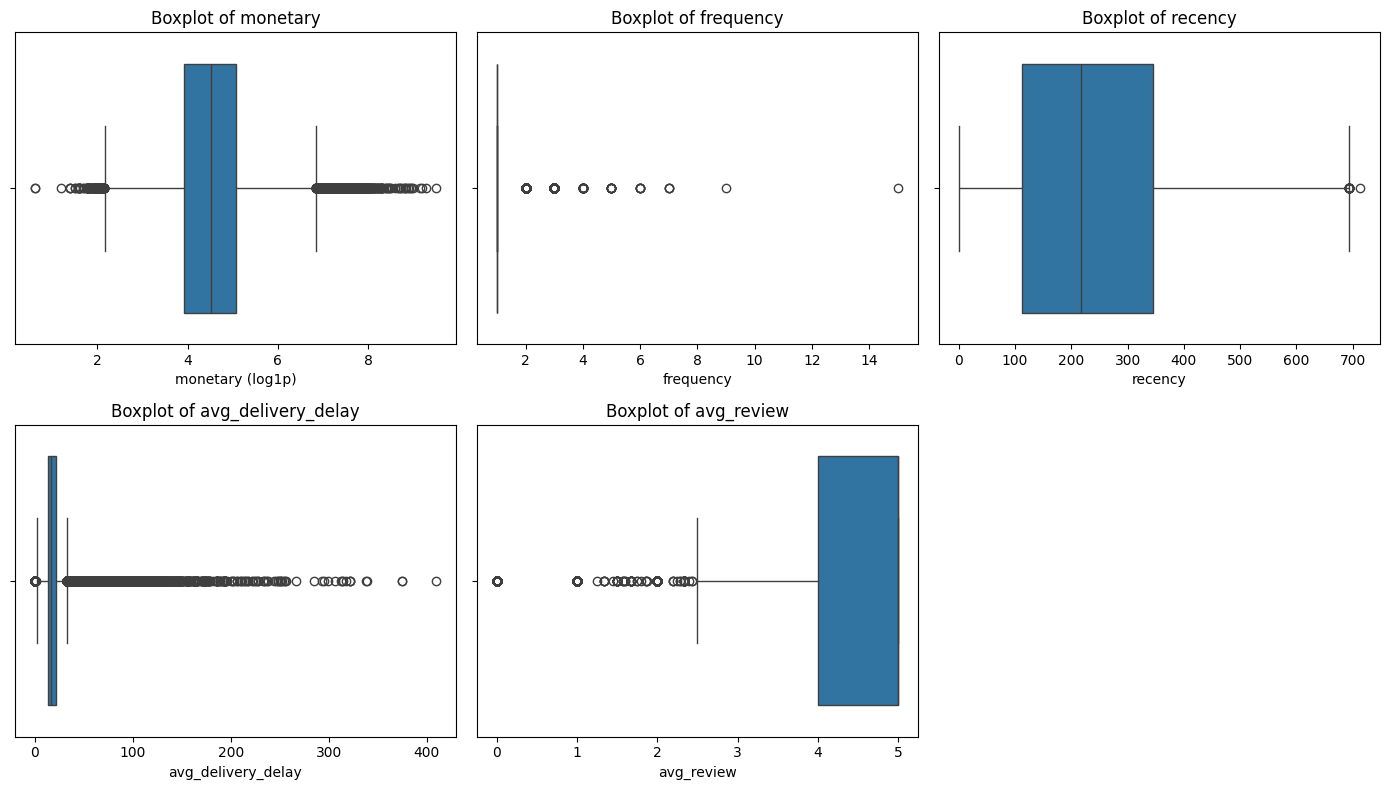

In [17]:
# Boxplots for key client features (log-transform monetary)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

features = ['monetary', 'frequency', 'recency', 'avg_delivery_delay', 'avg_review']
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i, feat in enumerate(features):
    ax = axes[i]
    if feat == 'monetary':
        # monetary often has long tails — use log1p for visualization
        sns.boxplot(x=np.log1p(client_features[feat].fillna(0)), ax=ax)
        ax.set_xlabel(feat + ' (log1p)')
    else:
        sns.boxplot(x=client_features[feat].fillna(0), ax=ax)
        ax.set_xlabel(feat)
    ax.set_title(f'Boxplot of {feat}')

# hide any unused subplot (we created 6, used 5)
if len(axes) > len(features):
    axes[-1].set_visible(False)

plt.tight_layout()
plt.show()
